# Prédiction de la tendance de l'épidémie

## Objectif
### Classer chaque jour comme :
### -  "hausse" : forte augmentation des cas
### -  "baisse" : forte diminution
### -  "stable" : variation faible

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données

In [2]:


# Chargement
df = pd.read_csv("../dataset/clean_covid19_data_v2.csv", parse_dates=["date"])
df = df[df["country"] == "Canada"].sort_values("date").reset_index(drop=True)


## Feature engineering + création de la classe

# Moyennes mobiles et lags
df["new_cases_7d_avg"] = df["new_cases"].rolling(7).mean()
df["new_deaths_7d_avg"] = df["new_deaths"].rolling(7).mean()
df["lag_1"] = df["new_cases"].shift(1)
df["lag_2"] = df["new_cases"].shift(2)
df["lag_7"] = df["new_cases"].shift(7)
df["delta"] = df["new_cases"] - df["lag_1"]
df["month"] = df["date"].dt.month
df["day_of_week"] = df["date"].dt.dayofweek

# Création des classes
def label_tendance(row):
    if row["delta"] > 0.05 * row["lag_1"]:
        return "hausse"
    elif row["delta"] < -0.05 * row["lag_1"]:
        return "baisse"
    else:
        return "stable"

df["tendance"] = df.apply(label_tendance, axis=1)


## Préparation du jeu de données

features = [
    "new_cases_7d_avg", "new_deaths_7d_avg",
    "lag_1", "lag_2", "lag_7", "month", "day_of_week",
    "reproduction_rate", "people_vaccinated", "stringency_index"
]
target = "tendance"

# Nettoyage
df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


## Modèle RandomForestClassifier

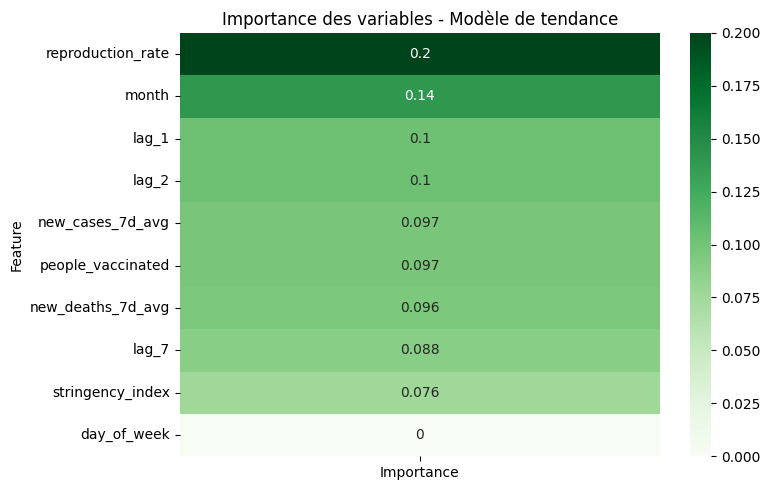

Modèle sauvegardé dans modele_tendance_covid_rf.pkl

 Rapport de classification :
              precision    recall  f1-score   support

      baisse       0.86      0.95      0.90        20
      hausse       0.67      0.93      0.78        15
      stable       1.00      0.20      0.33        10

    accuracy                           0.78        45
   macro avg       0.84      0.69      0.67        45
weighted avg       0.83      0.78      0.74        45



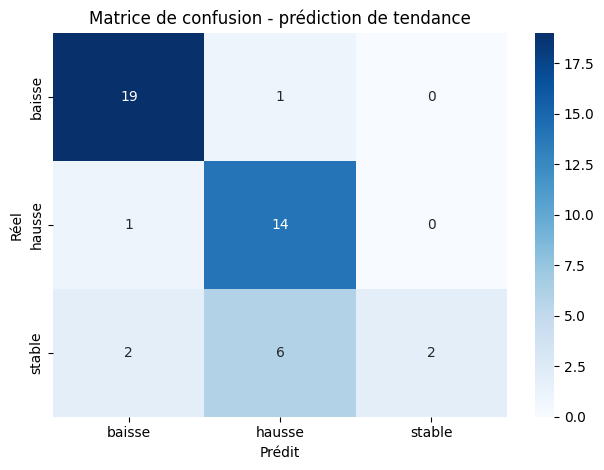

In [6]:


model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Importance des variables (heatmap)
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False).set_index("Feature")

plt.figure(figsize=(8, 5))
sns.heatmap(importance_df, annot=True, cmap="Greens")
plt.title("Importance des variables - Modèle de tendance")
plt.tight_layout()
plt.show()

# Sauvegarde du modèle
import joblib
joblib.dump(model, "../model/modele_tendance_covid_rf_canada.pkl")
print("Modèle sauvegardé dans modele_tendance_covid_rf.pkl")

## Évaluation

print("\n Rapport de classification :")
print(classification_report(y_test, y_pred))

sns.heatmap(
    confusion_matrix(y_test, y_pred), annot=True, fmt="d",
    cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_
)
plt.title("Matrice de confusion - prédiction de tendance")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

## XGBoost Classifier

c:\Users\wamba\Desktop\python\solution-ia-mspr\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:40:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


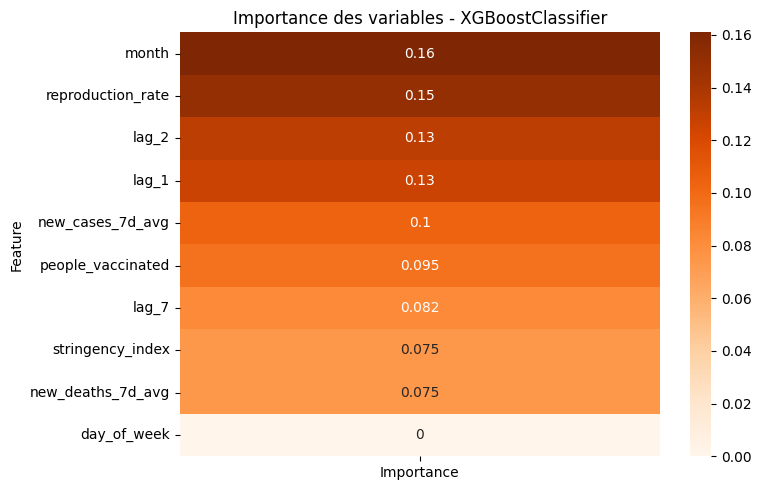


 Rapport XGBoost :
              precision    recall  f1-score   support

      baisse       0.80      0.80      0.80        20
      hausse       0.68      0.87      0.76        15
      stable       0.33      0.20      0.25        10

    accuracy                           0.69        45
   macro avg       0.61      0.62      0.60        45
weighted avg       0.66      0.69      0.67        45



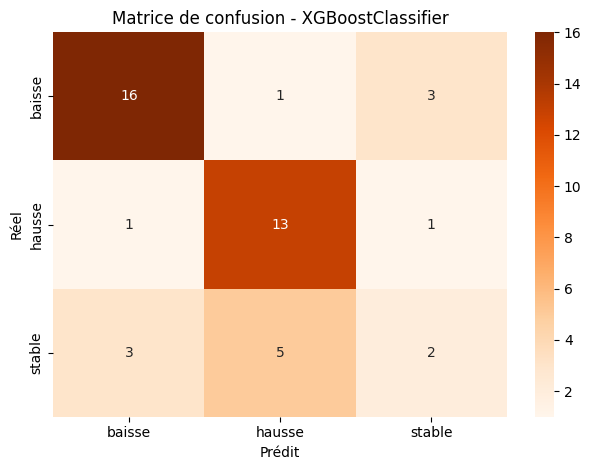

In [4]:
# Encodage des labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)
y_pred_xgb_enc = xgb_model.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

# Heatmap des features
xgb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values("Importance", ascending=False).set_index("Feature")

plt.figure(figsize=(8, 5))
sns.heatmap(xgb_importances, annot=True, cmap="Oranges")
plt.title("Importance des variables - XGBoostClassifier")
plt.tight_layout()
plt.show()

# Évaluation
print("\n Rapport XGBoost :")
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Oranges",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matrice de confusion - XGBoostClassifier")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

## Gradient Boosting Classifier

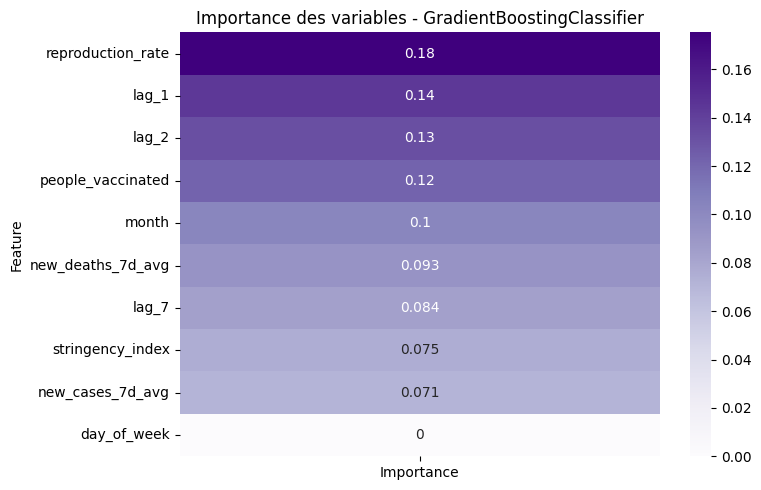


 Rapport Gradient Boosting :
              precision    recall  f1-score   support

      baisse       0.79      0.75      0.77        20
      hausse       0.68      0.87      0.76        15
      stable       0.29      0.20      0.24        10

    accuracy                           0.67        45
   macro avg       0.59      0.61      0.59        45
weighted avg       0.64      0.67      0.65        45



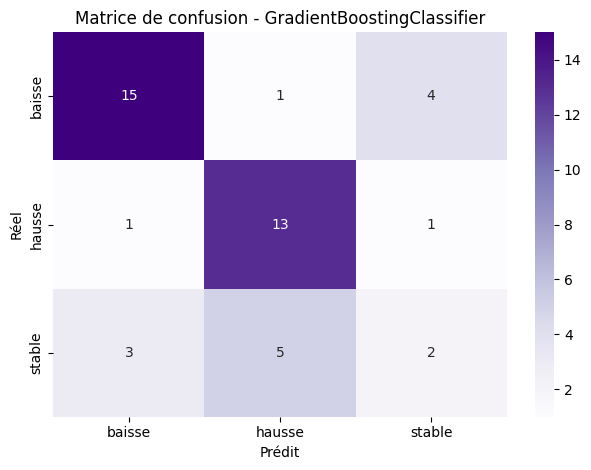

In [5]:
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Heatmap des features
gb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gb_model.feature_importances_
}).sort_values("Importance", ascending=False).set_index("Feature")

plt.figure(figsize=(8, 5))
sns.heatmap(gb_importances, annot=True, cmap="Purples")
plt.title("Importance des variables - GradientBoostingClassifier")
plt.tight_layout()
plt.show()

# Évaluation
print("\n Rapport Gradient Boosting :")
print(classification_report(y_test, y_pred_gb))
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt="d", cmap="Purples",
            xticklabels=gb_model.classes_, yticklabels=gb_model.classes_)
plt.title("Matrice de confusion - GradientBoostingClassifier")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


# Comparatif – Prédiction de la Tendance COVID-19 (Canada)

## Objectif
Déterminer le modèle de Machine Learning le plus efficace pour prédire la **tendance épidémique** quotidienne au Canada :
-  Hausse
-  Baisse
- Stable


## Modèles testés
- RandomForestClassifier
- XGBoostClassifier
- GradientBoostingClassifier


## Résultats

| Modèle                  | Accuracy | F1-score global | F1-baisse | F1-hausse | F1-stable |
|-------------------------|----------|-----------------|-----------|-----------|-----------|
| **Random Forest**       | **0.78** | **0.74**        | 0.90      | 0.78      | 0.33      |
| XGBoost                 | 0.69     | 0.67            | 0.80      | 0.76      | 0.25      |
| Gradient Boosting       | 0.67     | 0.65            | 0.77      | 0.76      | 0.24      |


## Analyse des performances

### Random Forest
- Meilleure **précision globale** (78 %)
- Meilleur équilibre sur toutes les classes
- Surtout très bon pour les cas **“baisse”** et **“hausse”**
- Difficulté sur les cas “stables”, comme tous les autres modèles, mais meilleure que les autres

### XGBoost
- Bonne performance sur “hausse” (rappel élevé)
- Moins stable sur “baisse”
- Plus faible sur les cas “stables”

### Gradient Boosting
- Résultats similaires à XGBoost mais légèrement moins bons globalement
- Comportement proche mais moins régulier


## Conclusion : Modèle retenu

Le **RandomForestClassifier** a été retenu comme modèle final pour la prédiction de la tendance épidémique au Canada car :
- Il fournit les **meilleurs scores globaux**
- Il est **robuste, stable, et interprétable**
- Il est facilement **exportable dans une API ou un dashboard**
- Il est déjà **entraîné et sauvegardé** dans `modele_tendance_covid_rf.pkl`


## Améliorations possibles

- Entraîner le modèle avec plus de données (plusieurs pays, périodes différentes)
- Rééquilibrer les classes (plus de cas "stables")
- Ajouter des signaux contextuels (météo, mobilité, politiques sanitaires)

